In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Пропусков в данных нет
df = pd.read_csv('Mall_Customers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [3]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
# Проверяем корректность значений
df['Genre'].value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

In [6]:
# Проставляем флаг
df['Genre'] = df['Genre'].apply(lambda x: 1 if x == 'Male' else 0)
df['Genre'].value_counts()

Genre
0    112
1     88
Name: count, dtype: int64

In [7]:
df.Age.mean()

38.85

In [8]:
# Переименовывыаем признаки так, чтобы не было пробелов
print(df.columns)
dictionary_names = {
    'Annual Income (k$)': 'Annual_Income_(k$)',
    'Spending Score (1-100)': 'Spending_Score_(1-100)' 
}
df.rename(dictionary_names, axis = 1, inplace=True)
print(df.columns)

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
Index(['CustomerID', 'Genre', 'Age', 'Annual_Income_(k$)',
       'Spending_Score_(1-100)'],
      dtype='object')


In [9]:
def calc_squared_error(values):
    mean_value = values.mean()
    res = sum([(v - mean_value) ** 2 for v in values]) / len(values)
    return res
# Доработка функции построения сплита и приведение в библиотечному виду

def calc_options(X, y, calc_criterion_value):
    feature_names = list(X.columns)
    max_information_gain = 0
    best_feature_split = None
    init_criterion_value = calc_criterion_value(y)
    # перебираем все признаки
    for feature_name in feature_names:
        # print(feature_name)
        
        # составляем значения для сплитов по признаку
        feature_values = X[feature_name]
        diff_feature_values = sorted(set(feature_values)) #[0, 1]
        
        # перебираем возможные сплиты по признаку
        for i in range(len(diff_feature_values) - 1):
            
            information_gain = init_criterion_value
            
            # считаем значение сплита
            split_value = (diff_feature_values[i] + diff_feature_values[i+1]) / 2
            # print(f'    Split value = {split_value}')
            
            # считаем хаотичность в левой группе + создаём масочку
            mask = X[feature_name] <= split_value
            values_in_group = y[mask]
            criterion_value_for_group = calc_criterion_value(values_in_group)
            ratio_for_group = len(values_in_group) / len(y)
            
            information_gain -= criterion_value_for_group * ratio_for_group
            
            # считаем хаотичность в правой группе
            mask = X[feature_name] > split_value
            values_in_group = y[mask]
            criterion_value_for_group = calc_criterion_value(values_in_group)
            ratio_for_group = len(values_in_group) / len(y)
            
            information_gain -= criterion_value_for_group * ratio_for_group
            
            # считаем прирост иноформации
            if max_information_gain < information_gain:
                max_information_gain = information_gain
                best_feature_split = feature_name
                best_feature_split_value = split_value
    
    # print(f'BEST feature_split: {best_feature_split} with information gain = {max_information_gain}')
    if max_information_gain == 0:
        return
    else:
        return best_feature_split, best_feature_split_value

In [10]:
# Функция построения решающего дерева, X -- фичи, y -- таргет
# max_depth: максимальная глубина, min_sample -- минимальное количество элементов в выборке для сплита
# current_depth -- на какой глубине мы производим разделение

def fit_regression_tree(X, y, calc_criterion_value, max_depth: int, min_sample = 2, current_depth = 0):
    
    if current_depth == max_depth or len(y) < min_sample:
        print(f'|{current_depth}| --- value: {round(y.mean(), 2)} длина {len(y)}, значения {" ".join(map(str, y.sort_values()))}')
        return
    # если нет, мы находимся в каком-то узле дерева, ищем оптимальное разделение
    result = calc_options(X, y, calc_criterion_value)
    if result == None:
        print(f'|{current_depth}| --- value: {round(y.mean(), 2)}, длина {len(y)}, данные однородны, значения {" ".join(map(str, y.sort_values()))}')
        return
    # сюда мы приходим, если разделение возможно
    # запускаем левую ветку
    print(f'|{current_depth}| Проход влево {result[0]} <= {result[1]}.')
    mask_left = (X[result[0]] <= result[1])
    fit_regression_tree(X[mask_left], y[mask_left], calc_criterion_value, max_depth,  min_sample, current_depth + 1)
    # Запускаем правую ветку
    print(f'|{current_depth}| Проход вправо {result[0]} > {result[1]}.')
    mask_right = X[result[0]] > result[1]
    fit_regression_tree(X[mask_right], y[mask_right], calc_criterion_value, max_depth,  min_sample, current_depth + 1)
    


In [11]:
# подготовка данных
features = df.drop(['Spending_Score_(1-100)', 'CustomerID'], axis = 1)
target = df['Spending_Score_(1-100)']
df.head()
target[len(target) - 1]

target

0      39
1      81
2       6
3      77
4      40
       ..
195    79
196    28
197    74
198    18
199    83
Name: Spending_Score_(1-100), Length: 200, dtype: int64

In [12]:
# попробуем сначала для теста запустить одну итерацию функции calc_options
calc_options(features, target, calc_squared_error)

('Age', 39.5)

In [13]:
# запуск решающего дерева при условии max_depth = 2
fit_regression_tree(features, target, calc_squared_error, max_depth = 2, min_sample = 1, current_depth = 0)

|0| Проход влево Age <= 39.5.
|1| Проход влево Age <= 20.5.
|2| --- value: 44.65 длина 17, значения 5 5 6 10 39 41 46 48 49 50 54 55 59 59 66 75 92
|1| Проход вправо Age > 20.5.
|2| --- value: 62.53 длина 99, значения 1 1 6 8 10 12 13 18 22 23 26 27 29 32 34 35 35 40 40 40 41 42 42 42 42 42 47 47 50 51 52 52 54 54 55 55 55 56 57 60 60 61 61 63 65 68 69 69 71 72 72 73 73 73 73 73 73 74 74 75 75 75 75 76 76 77 77 77 78 79 79 81 81 82 83 83 85 86 86 87 87 88 88 88 89 90 90 91 91 92 92 93 93 94 95 97 97 98 99
|0| Проход вправо Age > 39.5.
|1| Проход влево Annual_Income_(k$) <= 72.0.
|2| --- value: 41.77 длина 65, значения 3 4 4 5 9 11 14 14 14 15 17 28 29 31 32 35 35 36 40 41 41 42 42 42 43 43 43 44 45 46 46 46 46 46 47 47 48 48 48 48 49 49 50 50 50 51 51 52 52 52 53 55 55 55 56 56 56 57 58 58 59 59 59 60 95
|1| Проход вправо Annual_Income_(k$) > 72.0.
|2| --- value: 19.79 длина 19, значения 5 7 13 13 14 15 15 16 16 17 17 20 20 24 26 28 35 36 39


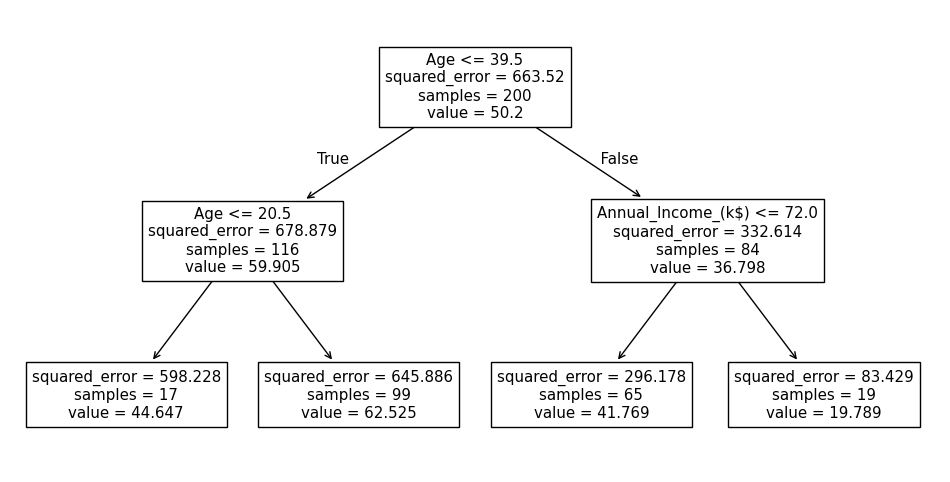

In [14]:
# Сравнение с библиотечной моделью -- результаты совпадают
model = DecisionTreeRegressor(max_depth=2, min_samples_leaf=1)
model.fit(features, target)
plt.figure(figsize=[12, 6])
tree.plot_tree(model, feature_names=list(features.columns));

In [15]:
# запуск решающего дерева при условии min_sample = 70
fit_regression_tree(features, target, calc_squared_error, max_depth = 10,  min_sample = 70, current_depth = 0)

|0| Проход влево Age <= 39.5.
|1| Проход влево Age <= 20.5.
|2| --- value: 44.65 длина 17, значения 5 5 6 10 39 41 46 48 49 50 54 55 59 59 66 75 92
|1| Проход вправо Age > 20.5.
|2| Проход влево Age <= 32.5.
|3| --- value: 66.59 длина 64, значения 12 18 29 34 40 40 41 42 42 42 42 47 47 50 51 52 52 54 54 55 55 56 57 61 63 65 68 69 69 71 72 73 73 73 73 73 73 74 74 75 76 77 77 77 78 79 81 81 82 83 83 86 86 87 87 88 88 89 92 93 93 94 97 97
|2| Проход вправо Age > 32.5.
|3| --- value: 55.09 длина 35, значения 1 1 6 8 10 13 22 23 26 27 32 35 35 40 42 55 60 60 61 72 75 75 75 76 79 85 88 90 90 91 91 92 95 98 99
|0| Проход вправо Age > 39.5.
|1| Проход влево Annual_Income_(k$) <= 72.0.
|2| --- value: 41.77 длина 65, значения 3 4 4 5 9 11 14 14 14 15 17 28 29 31 32 35 35 36 40 41 41 42 42 42 43 43 43 44 45 46 46 46 46 46 47 47 48 48 48 48 49 49 50 50 50 51 51 52 52 52 53 55 55 55 56 56 56 57 58 58 59 59 59 60 95
|1| Проход вправо Annual_Income_(k$) > 72.0.
|2| --- value: 19.79 длина 19, значения

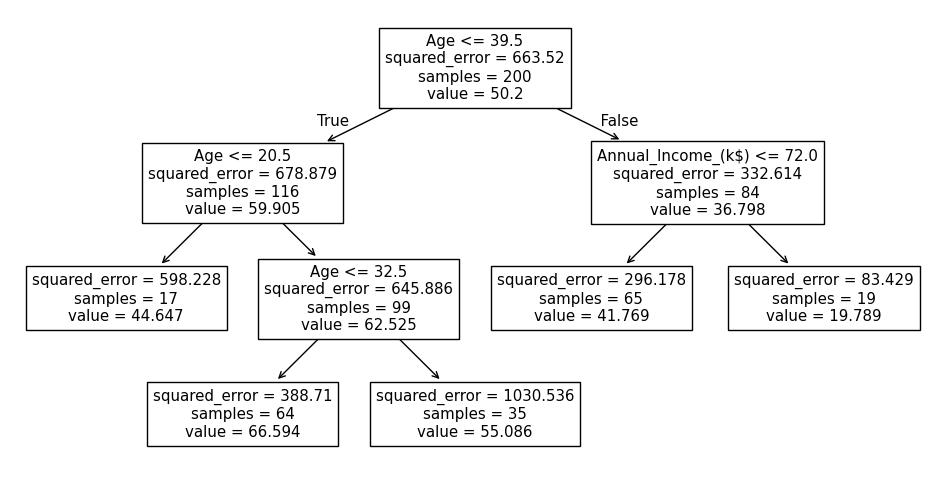

In [16]:
# Сравнение с библиотечной моделью -- библиотечная модель останавливается на первом шаге
model_ = DecisionTreeRegressor(max_depth=10, min_samples_split=70)
model_.fit(features, target)
plt.figure(figsize=[12, 6])
tree.plot_tree(model_, feature_names=list(features.columns));